<a href="https://colab.research.google.com/github/DomMc97/Running-Playlist/blob/main/spotify_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Clustering

A notebook in which I cluster my Liked Songs on Spotify in order to create playlists of similar audio features. I will then pick a playlist which is the most suitable for running.

To cluster the data I will use the unsupervised clustering technique of Gaussian Mixture Models (GMMs) I will use this method due to it's soft clustering feature which allows for songs which are similar to the songs in multiple playlists to be included in both. 


---



## Overview of GMM

Gaussian Mixture Models (GMMs) assume that there are a certain number of Gaussian distributions, and each of these distributions represent a cluster. This is based on the assumption that each sample $\vec{x_{i}}$ is generated in an IID fashion by the underlying density function: $$p(\vec{x}|\Theta) = \sum\limits_{k=1}^{K} \alpha_{k} p_{k}(\vec{x}|\mu_{k}, \Sigma_{k}) $$ where, $p_{k}(\vec{x}|\mu_{k}, \Sigma_{k})$ is one of the $K$ gaussian distributions, $\alpha_{k}$ are the mixture weights the probability that a randomly selected $\vec{x}$ was
generated by component $k$ and $\Theta=\{\alpha_{1}, ..., \alpha_{K}, \mu_{1}, ... \mu_{K}, \Sigma_{1}, ... \Sigma_{K}\}$ the model paramaters.    Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together.

Gaussian Mixture Models use the soft clustering technique for assigning data points to Gaussian distributions. For example consider the example below the circled datapoint has a 20% of being in the blue cluster and a 80% of being in the cyan cluster.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/Screenshot-from-2019-10-21-12-53-29-300x204.png)

### The Gaussian Distribution
Each of the $K$, the number of clusters, Gaussian distributions is goverened by the following multivariate probablity density function: $$ p_{k}(\vec{x}|\mu_{k}, \Sigma_{k}) = \frac{1}{\sqrt{(2 \pi)^{d} |\Sigma_{k}|}}\exp[-\frac{1}{2}(\vec{x}-\vec{\mu_{k}})\Sigma_{k}^{-1}(\vec{x}-\vec{\mu_{k}})^{T}]$$ where, $d$ is the dimensions of distribution, $\vec{x}$ is the $d$ dimensional input vector, $\vec{\mu}$ is $d$ dimensional vector of means and $\Sigma$ is a $d \times d$ covariance matrix.

### Expectation-Maximization
The values of each distributions $\vec{\mu_{k}}$ and $\Sigma_{k}$ are determined by a process known as Expectation-Maximization.

The algorithm is an iterative algorithm that starts from some initial estimate of the paramaeters (e.g., random), and then proceeds to
iteratively update them until convergence is detected. Each iteration consists of an E-step and an M-step.

**E-Step:** Denote the current parameter values as $\Theta$. Compute all $w_{ik}$ the membership weights: $$ w_{ik} = \frac{\alpha_{k} p_{k}(\vec{x}|\mu_{k},\Sigma_{k})}{\sum\limits_{m=1}^{K}\alpha_{k} p_{m}(\vec{x}|\mu_{m},\Sigma_{m})}$$ this is the probability that the sample $\vec{i}$ was created by distribution $k$ over the sum of the generation probablilities for each cluster. Therefore $w_{ik}$ represents the probability that distribution $k$ created the sample $\vec{x_{i}}$.

**M-Step:** Now use the membership weights and the data to calculate new parameter values. Let $N_{k} = \sum\limits_{i=1}^{N} w_{ik}$ the sum of the membership weights for the $k^{th}$ component—this is the effective number of data points assigned to component $k$. Now assign $\alpha_{k}^{new} = \frac{N_{k}}{k}$, $\vec{\mu_{k}^{new}} = \frac{1}{N_{k}}\sum\limits_{i=1}^{N} w_{ik} \vec{x_{i}}$ and $\Sigma_{k}^{new} = \frac{1}{N_{k}}\sum\limits_{i=1}^{N} w_{ik} (\vec{x_{i}} - \vec{\mu_{k}^{new}} )(\vec{x_{i}} - \vec{\mu_{k}^{new}} )^{T}$

We iterate through these steps until the value of the log-likelihood calculated after each iteration appears not to be changing in a significant manner from one iteration to the next.


## Set Up

Imports libraries.

In [1]:
# data analytics library
import pandas as pd

# scientific library
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures
from plotly.subplots import make_subplots

from string import ascii_uppercase

# 
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

In [2]:
# spotify library
!pip install Spotipy
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials

Mounts Google Drive.

In [3]:
# libraries for saving/loading data
from google.colab import drive
import pickle

# mount drive
drive.mount('/content/drive')

# root of all file paths used in notebook
root = '/content/drive/My Drive/Spotify/Data/'

Mounted at /content/drive


## Load Data

Loads in the scaled df of my liked song data.

In [4]:
scaled_df = pd.read_csv(root + 'scaledsongs.csv',index_col=0)
N, M = scaled_df.shape
print('Columns: ', M, '\nRows:', N)
scaled_df.head()

Columns:  9 
Rows: 2602


,name,id,key,acousticness,danceability,energy,loudness,speechiness,tempo
0,Sleep Walker,7KLikopJc6LCkohWF5QnHS,-0.102865,-0.464839,-0.438657,-0.984089,-0.355540,-0.567698,-0.130965
1,Sex Hair,0zHDpXbBpamkXVfXkTQeUT,-0.377382,-0.340965,-0.121657,0.977156,0.835729,-0.206493,1.516579
2,Caught Up,645hr7BS1p0a2tT5A4rj1b,-1.200935,-0.490868,-1.175867,0.081278,-0.692986,-0.258742,1.442419
3,Girl Like You,5ZsuhbdQSRS4wqggUrCz9e,-1.200935,1.375030,0.866205,0.299195,0.120407,0.025224,1.518193
4,The Difference,4nlvKIIetOWGIMyhjQXgOZ,-1.200935,0.868443,0.357530,0.553430,1.960149,0.734004,1.151212


Loads in the unscaled song data.

In [24]:
songs_df = pd.read_csv(root + 'mysongs.csv',index_col=0)
N, M = songs_df.shape
# normalize columns for radar plot
scaler = MinMaxScaler()
songs_df['tempo'] = scaler.fit_transform(np.array([songs_df['tempo']]).T)
songs_df['loudness'] = scaler.fit_transform(np.array([songs_df['loudness']]).T)
songs_df['key'] = scaler.fit_transform(np.array([songs_df['key']]).T)
print('Columns: ', M, '\nRows:', N)
songs_df.head()

Columns:  9 
Rows: 2602


,name,id,key,acousticness,danceability,energy,loudness,speechiness,tempo
0,Sleep Walker,7KLikopJc6LCkohWF5QnHS,0.454545,0.004970,0.452,0.611,0.744760,0.0336,0.470145
1,Sex Hair,0zHDpXbBpamkXVfXkTQeUT,0.363636,0.028200,0.495,0.935,0.859002,0.0495,0.764462
2,Caught Up,645hr7BS1p0a2tT5A4rj1b,0.090909,0.000089,0.352,0.787,0.712399,0.0472,0.751214
3,Girl Like You,5ZsuhbdQSRS4wqggUrCz9e,0.090909,0.350000,0.629,0.823,0.790403,0.0597,0.764751
4,The Difference,4nlvKIIetOWGIMyhjQXgOZ,0.090909,0.255000,0.560,0.865,0.966833,0.0909,0.699193


Create X the sample data from.

In [25]:
# X
X = scaled_df.iloc[:, 2:]
X.head()

,key,acousticness,danceability,energy,loudness,speechiness,tempo
0,-0.102865,-0.464839,-0.438657,-0.984089,-0.355540,-0.567698,-0.130965
1,-0.377382,-0.340965,-0.121657,0.977156,0.835729,-0.206493,1.516579
2,-1.200935,-0.490868,-1.175867,0.081278,-0.692986,-0.258742,1.442419
3,-1.200935,1.375030,0.866205,0.299195,0.120407,0.025224,1.518193
4,-1.200935,0.868443,0.357530,0.553430,1.960149,0.734004,1.151212


## Hyperparameter Selection

I would like the playlists to be of a size of roughly 100-300 clusters and I don't want too have to many playlists. So I will search a range of k from 11 to 13. With the following average playlist sizes (assuming hard clusters):

In [26]:
print('Average Cluster Size for 11 Clusters:', N/11)
print('Average Cluster Size for 12 Clusters:', N/12)
print('Average Cluster Size for 13 Clusters:', N/13)

Average Cluster Size for 11 Clusters: 236.54545454545453
Average Cluster Size for 12 Clusters: 216.83333333333334
Average Cluster Size for 13 Clusters: 200.15384615384616


Setting all other hyperparmeters to their default. I will now pick the number of clusters by picking the k which minimises the Bayesian information criterion which in theory recovers the true number of components only in the asymptotic regime (i.e. if much data is available and assuming that the data was actually generated i.i.d. from a mixture of Gaussian distribution). As well as 11-13 I will also search for $k$ 1-10 and 13-20 in order to see if this choice of scale is an appropriate choice in terms of bic.

In [27]:
model = []
bic = []
n = range(1, 20)

# fits the GMM model for n_components 11-13
for n_components in n:
    gm = GaussianMixture(n_components=n_components, random_state=0).fit(X)
    model.append(gm)
    bic.append(gm.bic(X))

Plot of bic scores.

[]

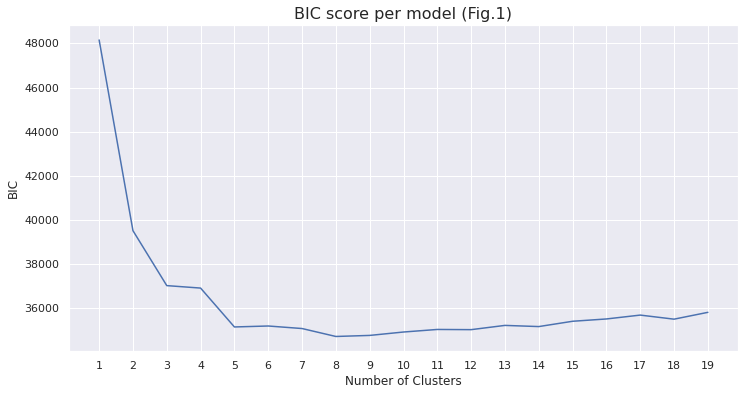

In [28]:
fig = plt.figure(figsize=(12,6))
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC score per model (Fig.1)', fontsize = '16')
plt.plot(n, bic)
plt.xticks(n)
plt.plot()

From this plot we can see that a $k=8$ is the optimum number of clusters. Out of the range 11-13 we can see that the number of clusters of $k=11$ is optimum. A final observation is that the BIC score seems to be almost monotonically increasing past $k=8$ indicating that $k=8$ is the global minimum. 

## Analyse The Clusterings
I will now analyse the playlists produced by these clusterings. To do so I will firstly attain them.

In [29]:
# a dictonary of the clusterings
clusterings = {}
for n_components in [8, 11]:
    # retreive the model
    gm = model[n_components-1]
    # get a boolean matrix of whether the node is in a cluster
    prob = gm.predict_proba(X)
    indicator = prob > 0.4
    # attain the playlists
    playlists = []
    for i in range(n_components):
        cluster_i = indicator[:,i]
        playlist = songs_df[cluster_i]
        playlists.append(playlist)
    # get a list of the cluster sizes
    sizes = [len(playlist) for playlist in playlists]
    # add the results to a dictionary
    clusterings[n_components] = {'playlist':playlists,'sizes':sizes}

Stats relating to the distribution of cluster sizes.

k: 8 
Mean cluster size: 338.38
Total number of songs: 2707


k: 11 
Mean cluster size: 246.73
Total number of songs: 2714


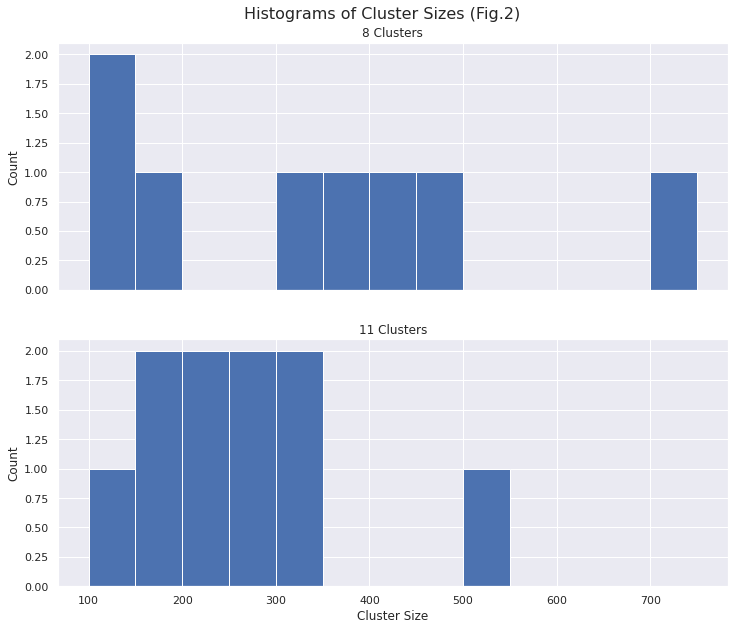

In [75]:
# the cluster sizes arrays
sizes_8 = clusterings[8]['sizes']
sizes_11 = clusterings[11]['sizes']

# print cluster stats 
print('k: 8 \nMean cluster size: %.2f\nTotal number of songs: %.f\n\n'%(
    np.mean(sizes_8), sum(sizes_8))) 

print('k: 11 \nMean cluster size: %.2f\nTotal number of songs: %.f'%(
    np.mean(sizes_11), sum(sizes_11))) 

# histograms
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,10))
bins = np.arange(100, 800, 50)
plt.xlabel('Cluster Size')
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')
ax1.set_title('8 Clusters')
ax2.set_title('11 Clusters')
plt.suptitle('Histograms of Cluster Sizes (Fig.2)', y=0.93, fontsize='16')
ax1.hist(sizes_8, bins)
ax2.hist(sizes_11, bins)
plt.show()

We can see as excpected that the clustering into 11 clusters fits my specification for clusters to contain 100-300 songs more tightly. Interestingly both clusterings contain one large clustering.

In [119]:
# T-SNE to 2 components
tsne = TSNE(perplexity=20, n_iter=1000)
tsne_results = tsne.fit_transform(X)

# create dataframe to store results
d = {'x': tsne_results[:, 0], 'y': tsne_results[:, 1], '8': model[7].predict(X), '11':model[10].predict(X)} 
clusters = pd.DataFrame(data=d)

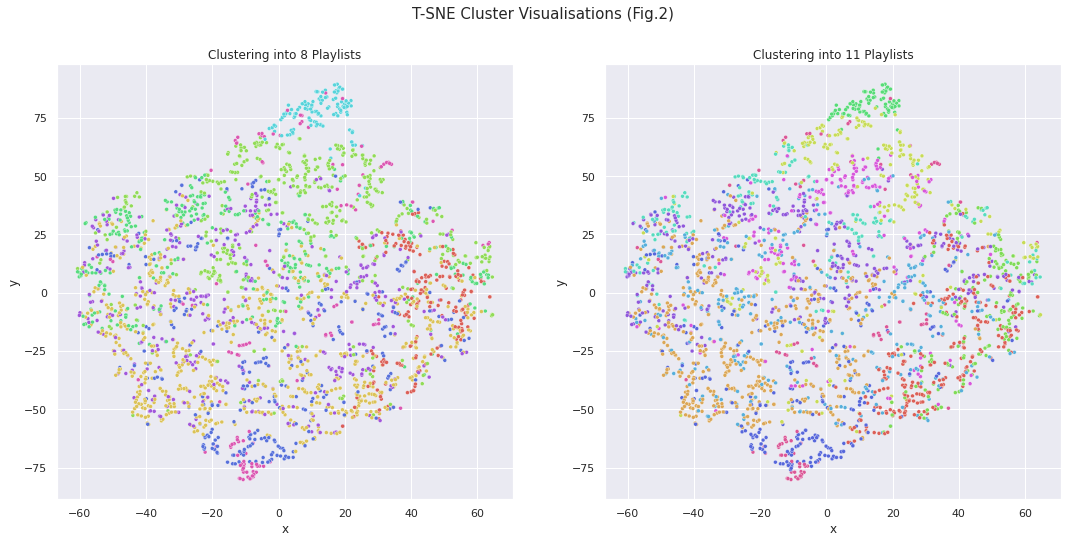

In [120]:
# creates figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,8))

# sets title 
fig.suptitle('T-SNE Cluster Visualisations (Fig.3)', fontsize=15)

# feature matrix clustering
sns.scatterplot(
    x="x", y="y",
    hue="8",
    palette=sns.color_palette("hls", 8),
    data=clusters,
    s=15,
    legend=False,
    ax=ax1
)

# set sub title
ax1.set_title('Clustering into 8 Playlists')

sns.scatterplot(
    x="x", y="y",
    hue="11",
    palette=sns.color_palette("hls", 11),
    data=clusters,
    s=15,
    legend=False,
    ax=ax2
)

# set sub title
ax2.set_title('Clustering into 11 Playlists')

plt.show()

I will now plotting the mean variables for each cluster (the centroids).

In [93]:
# the audio features to plot
categories = ['key', 'acousticness', 'danceability', 'energy',  'loudness',
         'speechiness', 'tempo','key']

# create fig
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{"type":"polar"}, {"type":"polar"}]],
                    subplot_titles=('Clustering Into 8 Playlists', 
                                    'Clustering Into 11 Playlists'))

# obtains and plots playlist from the clustering into 8 playlists
playlists = clusterings[8]['playlist']
for i, playlist in enumerate(playlists):
    # finds the mean of each feature
    x = list(playlist.mean())
    x.append(x[0])

    # makes radar plot
    fig.add_trace(go.Scatterpolar(
          r=x,
          theta=categories,
          fill='toself',
          name='Cluster ' + ascii_uppercase[i],
           visible='legendonly'
    ), row=1, col=1)

# obtains and plots playlist from the clustering into 11 playlists
playlists = clusterings[11]['playlist']
for i, playlist in enumerate(playlists):
   # finds the mean of each feature
    x = list(playlist.mean())
    x.append(x[0])

    # makes radar plot
    fig.add_trace(go.Scatterpolar(
          r=x,
          theta=categories,
          fill='toself',
          name='Cluster ' + str(i+1),
           visible='legendonly'
    ), row=1, col=2)

# update the polar grids
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
    polar2=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    ))
)

# update the layout
fig.update_layout(height=600, width=1400,
                  title_text='Radar Plot of All Clusters (Fig.4)')

# change subplot title location
for annotation in fig['layout']['annotations']: 
        annotation['yanchor']='bottom'
        annotation['y']=1.02
        annotation['yref']='paper'

# show the plot
fig.show()

### Create Playlists

I will now create all the 11 playlists in spotify to analyse the playlists sonically. To do this I must first access my Spotify API.

In [83]:
# user credentials
cid ='<My CID>'
secret = '<My Secret ID>'
username = '<My Username>'
scope = 'user-library-read playlist-modify-public playlist-modify-private'
redirect_uri='http://localhost:8888/callback/'

# access token
client_credentials_manager = spotipy.oauth2.SpotifyOAuth(
    scope=scope,
    username=username,
    client_id=cid,
     client_secret=secret,
      redirect_uri=redirect_uri,
      open_browser=False)

# aquires access to data
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

I will now create the playlists.

In [ ]:
for i, playlist_df in enumerate(playlists):

    # create playlist
    sp_playlist = sp.user_playlist_create(username, name='Cluster ' + str(i+1),
                                      public=False, description='')
    # add songs
    offset=0
    while offset <= len(playlist_df):
        songs = playlist_df['id'][offset:offset+100] 
        offset += 100
        sp.user_playlist_add_tracks(username, sp_playlist['id'], songs) 

## Review
* **Cluster 1:** Cluster 1 consists of mid-tempo indie rock songs with a low key bass. 

* **Cluster 2:** Cluster 2 consists of mid-tempo indie rock songs with a high key bass. These songs can be described as 'Breezy' songs.

* **Cluster 3:** Cluster 3 consits of low tempo indie songs with walking basses.

* **Cluster 4:** Cluster 4 consists of poppy upbeat indie songs.

* **Cluster 5:** Cluster 5 consists of acoustic relaxing songs.

* **Cluster 6:** Cluster 6 consists of light dancey indie songs.

* **Cluster 7:** Cluster 7 consists of punchy songs.

* **Cluster 8:** Cluster 8 consists of Chaotic arhythmic songs.

* **Cluster 9:** Cluster 9 consists of low tempo indie songs where the melody seems to faster than the lyrics.

* **Cluster 10:** Cluster 10 seems to be a random asortment of songs, likely meaning this playlist is an adhoc playlist of songs which don't fit into a distinct category.

* **Cluster 11:** Cluster 11 consists of guitar led strummy songs.

Of all the playlists cluster 8 songs have from empirical testing seems to be the best playlist to run too.
